In [1]:
!python --version

Python 2.7.13 :: Anaconda custom (x86_64)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Create Dataset

In [3]:
np.random.seed(11)

size = 300
m, b = 2, 6
X_setup = np.arange(0,10,10.0/size)
X1 = (m * X_setup) + b + np.random.normal(loc=0, scale=2.5, size=size)
X2 = (m * X_setup) + 0 + np.random.normal(loc=0, scale=2.5, size=size)

In [4]:
df = pd.DataFrame(X1, columns=["X1"])
df["X2"] = X2
df["X3"] = np.sqrt(np.abs(df.X2)) + np.random.normal(loc=0, scale=1.5, size=len(X_setup)) 
df["X4"] = np.random.choice([0,0.25,0.5,0.75,1,1.25,1.5], size=len(X_setup)) * X1
df["X5"] = np.random.binomial(n=1, p=0.5, size=len(X_setup))
df["X6"] = np.random.uniform(low=-1, high=15, size=size)
df['target'] = np.where(X2 > (0.65*X1), 1, 0)

In [5]:
# add complexity to data by flipping a few class values
np.random.seed(99)
idx = np.random.choice(range(100), size=7)
df.loc[idx, 'target'] = 1

In [6]:
df.describe()

,X1,X2,X3,X4,X5,X6,target
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,15.966104,9.945122,2.919030,11.748443,0.470000,7.311400,0.466667
std,6.245121,6.547832,1.872351,10.264681,0.499933,4.478365,0.499721
min,-0.433296,-4.270233,-2.507568,-0.216648,0.000000,-0.962258,0.000000
25%,11.121668,4.961865,1.575164,4.039593,0.000000,3.620345,0.000000
50%,15.615172,9.836169,3.010072,9.014460,0.000000,7.326372,0.000000
75%,21.072068,14.858777,4.133249,18.040023,1.000000,11.275638,1.000000
max,29.920700,24.843277,8.035843,44.203770,1.000000,14.972368,1.000000


# Plot Data

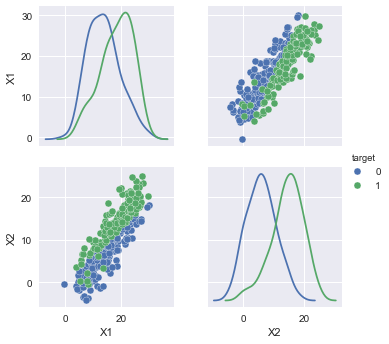

In [7]:
sns.pairplot(df, vars=["X1","X2"], hue="target", diag_kind='kde');

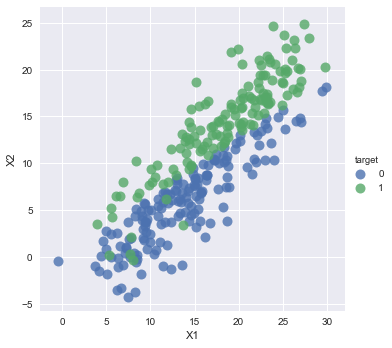

In [8]:
sns.lmplot('X1', 'X2',
           data=df,
           fit_reg=False,
           hue="target",  
           scatter_kws={"marker": "D", "s": 100});

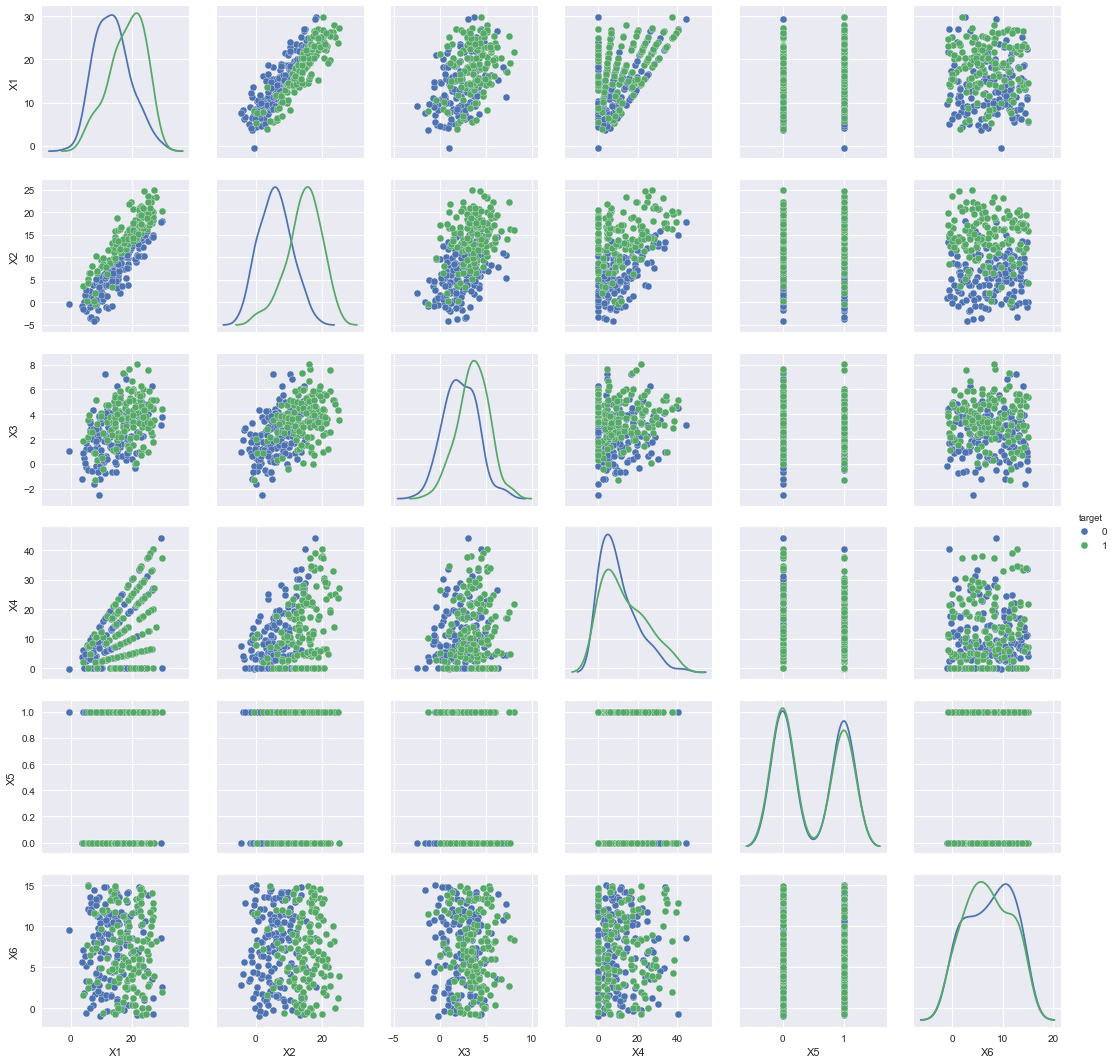

In [9]:
sns.pairplot(df, vars=["X1","X2","X3","X4","X5","X6"], hue="target", diag_kind="kde");

---

# Machine Learning

In [10]:
# Setup
X = df.copy()
y = X.pop('target')

from sklearn.metrics import log_loss, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### KNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, 
                           weights='uniform', 
                           algorithm='auto', 
                           leaf_size=30, 
                           p=2, metric='euclidean', 
                           metric_params=None, 
                           n_jobs=-1)
knn.fit(X_train, y_train)
knn.score(X_train, y_train), knn.score(X_test, y_test), log_loss(y_test, knn.predict_proba(X_test))

(0.87083333333333335, 0.83333333333333337, 2.0035499127219114)

In [12]:
confusion_matrix(y_test, knn.predict(X_test))

array([[25,  3],
       [ 7, 25]])

### KNN w/Grid Search

In [13]:
# define the parameter values that should be searched
k_range = range(1, 15)
weight_options = ['uniform', 'distance']
# create a parameter grid: map the parameter names to the values that should be searched
knn_param_grid = dict(n_neighbors=k_range, weights=weight_options)

knn_grid = GridSearchCV(knn, knn_param_grid, cv=10, scoring='accuracy')
knn_grid.fit(X_train, y_train)
knn_grid.score(X_train, y_train), knn_grid.score(X_test, y_test), log_loss(y_test, knn_grid.predict_proba(X_test))

(0.86250000000000004, 0.81666666666666665, 0.98710488705422039)

In [14]:
confusion_matrix(y_test, knn_grid.predict(X_test))

array([[25,  3],
       [ 8, 24]])

### KNN w/Randomized Search

In [54]:
knn_rand = RandomizedSearchCV(knn, knn_param_grid, cv=10, scoring='neg_log_loss')
knn_rand.fit(X_train, y_train)
knn_rand.score(X_train, y_train), knn_rand.score(X_test, y_test), log_loss(y_test, knn_rand.predict_proba(X_test))

(-0.38793281837743981, -0.48724447630926299, 0.48724447630926299)

In [55]:
confusion_matrix(y_test, knn_rand.predict(X_test))

array([[25,  3],
       [ 9, 23]])

---

### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', 
                        dual=False, 
                        tol=0.0001, 
                        C=1.0, 
                        fit_intercept=True, 
                        intercept_scaling=1, 
                        class_weight=None, 
                        random_state=10, 
                        solver='liblinear', 
                        max_iter=100, 
                        multi_class='ovr', 
                        verbose=0, 
                        warm_start=False, 
                        n_jobs=-1)
lr.fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_test, y_test), log_loss(y_test, lr.predict_proba(X_test))

(0.97916666666666663, 0.93333333333333335, 0.25906746473963677)

In [18]:
confusion_matrix(y_test, lr.predict(X_test))

array([[26,  2],
       [ 2, 30]])

### Logistic Regression w/Grid Search

In [52]:
# create a parameter grid: map the parameter names to the values that should be searched
lr_param_grid = dict(penalty=['l1', 'l2'], C=np.geomspace(0.001, 10, num=5))

lr_grid = GridSearchCV(lr, lr_param_grid, cv=10, scoring='neg_log_loss')
lr_grid.fit(X_train, y_train)
lr_grid.score(X_train, y_train), lr_grid.score(X_test, y_test), log_loss(y_test, lr_grid.predict_proba(X_test))

(-0.21511152488394641, -0.25591617452981014, 0.25591617452981014)

In [53]:
confusion_matrix(y_test, lr_grid.predict(X_test))

array([[27,  1],
       [ 2, 30]])

In [21]:
lr_grid.cv_results_

{'mean_fit_time': array([ 0.0023293 ,  0.00346782,  0.00292089,  0.0013484 ,  0.00227671,
         0.00128653,  0.00461559,  0.00215616,  0.00731428,  0.00214636]),
 'mean_score_time': array([ 0.00057483,  0.00082576,  0.00059793,  0.00032361,  0.00026822,
         0.00031848,  0.00063205,  0.00055122,  0.00083902,  0.00046225]),
 'mean_test_score': array([ 0.55      ,  0.84166667,  0.8625    ,  0.925     ,  0.95833333,
         0.95416667,  0.9625    ,  0.95833333,  0.95833333,  0.95833333]),
 'mean_train_score': array([ 0.55000042,  0.8444474 ,  0.88565362,  0.92315391,  0.97038086,
         0.97593217,  0.97500622,  0.97732321,  0.97731892,  0.97778189]),
 'param_C': masked_array(data = [0.001 0.001 0.01 0.01 0.10000000000000001 0.10000000000000001 1.0 1.0 10.0
  10.0],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'param_penalty': masked_array(data = ['l1' 'l2' 'l1' 'l2' 'l1' 'l2' 'l1' 'l2' 'l1' 'l2'],
              ma

---

### SVM

In [22]:
from sklearn.svm import LinearSVC

svc = LinearSVC(penalty='l2', 
                loss='hinge', 
                dual=True, 
                tol=0.0001, 
                C=1.0, 
                multi_class='ovr', 
                fit_intercept=True, 
                intercept_scaling=1, 
                class_weight=None, 
                verbose=0, 
                random_state=42, 
                max_iter=1000)
svc.fit(X_train, y_train)
svc.score(X_train, y_train), svc.score(X_test, y_test)

(0.96250000000000002, 0.96666666666666667)

In [23]:
confusion_matrix(y_test, svc.predict(X_test))

array([[28,  0],
       [ 2, 30]])

### SVM w/Grid Search

In [50]:
# create a parameter grid: map the parameter names to the values that should be searched
svc_param_grid = dict(penalty=['l2'], loss=['hinge','squared_hinge'], C=np.geomspace(0.001, 10, num=5))

svc_grid = GridSearchCV(svc, svc_param_grid, cv=10, scoring='accuracy')
svc_grid.fit(X_train, y_train)
svc_grid.score(X_train, y_train), svc_grid.score(X_test, y_test)

(0.97916666666666663, 0.94999999999999996)

In [51]:
confusion_matrix(y_test, svc_grid.predict(X_test))

array([[27,  1],
       [ 2, 30]])

---

### Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini', 
                            splitter='best', 
                            max_depth=None, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=13, 
                            max_leaf_nodes=None, 
                            min_impurity_split=1e-07, 
                            class_weight=None, 
                            presort=False)
dt.fit(X_train, y_train)
dt.score(X_train, y_train), dt.score(X_test, y_test), log_loss(y_test, dt.predict_proba(X_test)) 

(1.0, 0.78333333333333333, 7.4834015522306476)

In [27]:
confusion_matrix(y_test, dt.predict(X_test))

array([[23,  5],
       [ 8, 24]])

### Decision Tree w/Grid Search

In [47]:
# create a parameter grid: map the parameter names to the values that should be searched
dt_param_grid = dict(criterion=['gini','entropy'], max_depth=range(1,7), min_samples_leaf=range(1,5))

dt_grid = GridSearchCV(dt, dt_param_grid, cv=10, scoring='neg_log_loss')
dt_grid.fit(X_train, y_train)
dt_grid.score(X_train, y_train), dt_grid.score(X_test, y_test), log_loss(y_test, dt_grid.predict_proba(X_test))

(-0.4296909379159855, -0.53965725817989629, 0.53965725817989629)

In [48]:
confusion_matrix(y_test, dt_grid.predict(X_test))

array([[24,  4],
       [ 9, 23]])

---

### Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, 
                            criterion='gini', 
                            max_depth=None, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features='auto', 
                            max_leaf_nodes=None, 
                            min_impurity_split=1e-07, 
                            bootstrap=True, 
                            oob_score=False, 
                            n_jobs=-1, 
                            random_state=17, 
                            verbose=0, 
                            warm_start=False, 
                            class_weight=None)
rf.fit(X_train, y_train)
rf.score(X_train, y_train), rf.score(X_test, y_test), log_loss(y_test, rf.predict_proba(X_test))

(1.0, 0.83333333333333337, 0.39647677117341329)

In [31]:
confusion_matrix(y_test, rf.predict(X_test))

array([[24,  4],
       [ 6, 26]])

### Random Forest w/Grid Search

In [45]:
# create a parameter grid: map the parameter names to the values that should be searched
rf_param_grid = dict(criterion=['gini','entropy'], max_depth=range(2,7))

rf_grid = GridSearchCV(rf, rf_param_grid, cv=10, scoring='neg_log_loss')
rf_grid.fit(X_train, y_train)
rf_grid.score(X_train, y_train), rf_grid.score(X_test, y_test), log_loss(y_test, rf_grid.predict_proba(X_test))

(-0.16003147761888592, -0.40714728882012519, 0.40714728882012519)

In [46]:
confusion_matrix(y_test, rf_grid.predict(X_test))

array([[24,  4],
       [ 6, 26]])

---

### Gradient Boosted Classifier

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(loss='deviance', 
                                 learning_rate=0.1, 
                                 n_estimators=50, 
                                 subsample=1.0, 
                                 criterion='friedman_mse', 
                                 min_samples_split=2, 
                                 min_samples_leaf=1, 
                                 min_weight_fraction_leaf=0.0, 
                                 max_depth=3, 
                                 min_impurity_split=1e-07, 
                                 init=None, 
                                 random_state=123, 
                                 max_features=None, 
                                 verbose=0, 
                                 max_leaf_nodes=None, 
                                 warm_start=False, 
                                 presort='auto')
gbc.fit(X_train, y_train)
gbc.score(X_train, y_train), gbc.score(X_test, y_test), log_loss(y_test, gbc.predict_proba(X_test))

(0.98750000000000004, 0.90000000000000002, 0.33492256390670411)

In [44]:
confusion_matrix(y_test, gbc.predict(X_test))

array([[26,  2],
       [ 4, 28]])

### Gradient Boosted Classifier w/Grid Search

In [39]:
# create a parameter grid: map the parameter names to the values that should be searched
gbc_param_grid = dict(loss=['deviance','exponential'], 
                      max_depth=range(2,5), 
                      n_estimators=[25,50], 
                      learning_rate=[0.001, 0.01, 0.1])

gbc_grid = GridSearchCV(gbc, gbc_param_grid, cv=5, scoring='neg_log_loss')
gbc_grid.fit(X_train, y_train)
gbc_grid.score(X_train, y_train), gbc_grid.score(X_test, y_test), log_loss(y_test, gbc_grid.predict_proba(X_test))

(-0.1877619911744173, -0.33459680601552455, 0.33459680601552455)

In [40]:
confusion_matrix(y_test, gbc_grid.predict(X_test))

array([[26,  2],
       [ 5, 27]])